In [1]:
import mysql.connector, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
cnx = mysql.connector.connect(user='dbuser', password='dbpass', database='zipcode')
cursor = cnx.cursor()

In [68]:
fields = ['population',
          'employment',
          'area',
          'hunits',
          'sing_det',
          'sing_att',
          'duplex',
          'three_four',
          'five_nine',
          'ten_nineteen',
          'twenty_plus',
          '2014_later',
          '2010_2013',
          '2000_2009',
          '1990_1999',
          '1980_1989',
          '1970_1979',
          '1960_1969',
          '1950_1959',
          '1940_1949',
          '1939_older']
type_cat = ['sing_det',
          'sing_att',
          'duplex',
          'three_four',
          'five_nine',
          'ten_nineteen',
          'twenty_plus']
age_cat = ['2000_2009',
          '1990_1999',
          '1980_1989',
          '1970_1979',
          '1960_1969',
          '1950_1959',
          '1940_1949',
          '1939_older']

In [69]:
cursor.execute("SELECT {0} FROM zip_housing;".format(", ".join(fields)))
rawdata = cursor.fetchall()
df = pd.DataFrame(rawdata, columns = fields)
df = df.drop(df[df.hunits==0].index) # remove rows with zero housing units!

In [70]:
sum(df['hunits']), sum(df[type_cat].sum(axis=0)), sum(df[['2014_later','2010_2013'] + age_cat].sum(axis=0))

(134913539, 126319534, 134913539)

Note that the number of housing units counted in the date ranges is not the same as the number of units counted by type!

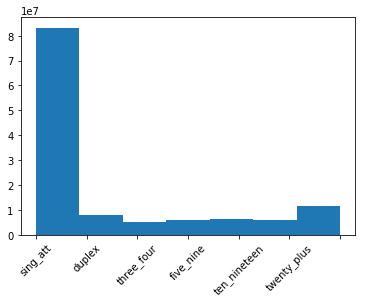

In [59]:
data = {k: v for k, v in enumerate(df[type_cat].sum(axis=0))}
ax = plt.subplot()
ax.hist(list(data.keys()), weights=list(data.values()), bins=7)
ax.set_xticklabels(type_cat + [''], rotation=45)
plt.show() # This has a display problem!!!

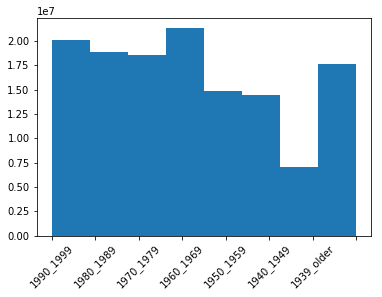

In [60]:
data = {k: v for k, v in enumerate(df[age_cat].sum(axis=0))}
ax = plt.subplot()
plt.hist(list(data.keys()), weights=list(data.values()), bins=8)
ax.set_xticklabels(age_cat, rotation=45)
plt.show() # This has a display problem!!!

In [128]:
mode_map = pd.concat([df[age_cat].idxmax(axis=1), (df['population'])/df['area'], df['population'], df['hunits']], axis=1)
mode_map.columns = ['age_mode', 'density', 'population', 'hunits']

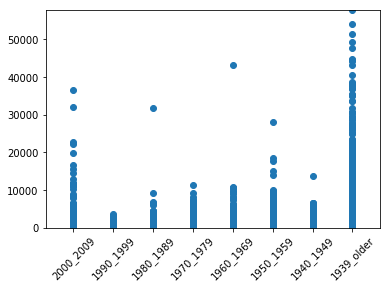

In [12]:
acmap = {name: i for i, name in enumerate(age_cat)}
ax = plt.subplot()
ax.plot([acmap[label] for label in mode_map['age_mode']], mode_map['density'], 'o')
plt.xticks(range(len(age_cat)), age_cat)
ax.margins(0.1, 0)
ax.set_xticklabels(age_cat, rotation=45)
plt.show()

In [26]:
def cum_dens_by_modeage(agelist):
    modes = mode_map[mode_map['age_mode'].isin(agelist)][['density', 'population']]
    modes['bin'] = pd.cut(modes['density'], [i*100 for i in rng], labels = [i for i in rng[:-1]])
    sums = [modes[modes['bin']==i]['population'].sum() for i in rng]
    cums = [sum(sums[:i]) for i in range(len(sums))]
    cums = cums / cums[-1]
    return cums

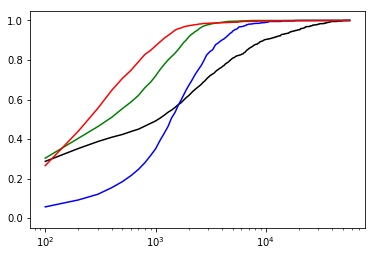

In [28]:
rng = range(0, int(max(mode_map['density'])/100))
cum_1930 = cum_dens_by_modeage(['1939_older'])
cum_lo = cum_dens_by_modeage(['1940_1949', '1950_1959', '1960_1969'])
cum_hi = cum_dens_by_modeage(['1970_1979', '1980_1989', '1990_1999'])
cum_2000 = cum_dens_by_modeage(['2000_2009'])
xs = [i*100 for i in rng]
plt.semilogx(xs, cum_1930, 'k-', xs, cum_lo, 'b-', xs, cum_hi, 'g-', xs, cum_2000, 'r-')
plt.show()

Pre-1940 is in black, 1940-1970 is in blue, 1970-2000 is in green, and after 2000 is in red

For comparison, the highest residential density in Washington DC is in the Adams-Morgan neighborhood at 15000 people per km$^2$. The density of Arlington from Ballston to Rosslyn metro stops is about 6000 people per km$^2$, while around George Mason it is 1500 people per km$^2$. The area around Front Royal, west of I-66 is about 100 people per km$^2$. 

In [62]:
cat_data = np.empty((7, 8))
for i, row in enumerate(type_cat):
    for j, col in enumerate(age_cat):
        cat_data[i, j] = sum(df[row]*df[col]/df['hunits'])
trutab = pd.DataFrame(cat_data, index=type_cat, columns=age_cat, dtype=int)
trutab

,2000_2009,1990_1999,1980_1989,1970_1979,1960_1969,1950_1959,1940_1949,1939_older
sing_det,13231648,12383720,11622307,13186186,8981531,8881509,4171739,9434389
sing_att,1080944,1057279,1117296,1219262,876154,868056,460750,1147528
duplex,481991,451096,493335,639427,569156,650298,396436,1294500
three_four,672204,645731,725539,887440,686525,689152,380892,1204765
five_nine,825655,819087,911708,1061701,763556,704955,345267,925055
ten_nineteen,829216,805582,907553,1026481,719441,644608,296961,730331
twenty_plus,1456613,1206455,1436357,1784572,1436910,1335572,694701,2119241


Here are the results of a $\chi^2$ test of independence

In [63]:
chi2, p, dof, exps = stats.chi2_contingency(trutab)
exptab = pd.DataFrame(exps, index=type_cat, columns=age_cat, dtype=int)
chi2, p

(2146451.9082430019, 0.0)

With a $p$ value of 0 we can, with very high confidence, reject the hull hypothesis that building type and age are independent. 

In [64]:
def color_neg_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

In [67]:
pct = (trutab - exptab)/exptab
pct.style.applymap(color_neg_red)

Looking at the individual building types, we can see that large apartment complexes were much more common before 1970, while single family homes were more common after. In particular, duplexes and three-four unit apartments were much more common before WWII, and much less common recently. 

In [123]:
df[type_cat].sum(axis=0)

sing_det        83240443
sing_att         7944467
duplex           5030772
three_four       5966646
five_nine        6446918
ten_nineteen     6052662
twenty_plus     11637626
dtype: int64

In [84]:
df[type_cat].sum(axis=0)/sum(df['hunits'])

sing_det        0.616991
sing_att        0.058886
duplex          0.037289
three_four      0.044226
five_nine       0.047786
ten_nineteen    0.044863
twenty_plus     0.086260
dtype: float64

Plot regression where 10% of housing in a certain category is used as a feature

In [117]:
cat10 = pd.DataFrame(df['population']/df['area'], columns=['density'])
for name in ['sing_att', 'duplex', 'three_four', 'five_nine', 'ten_nineteen', 'twenty_plus']:
    cat10[name] = df[name] / df['hunits'] > 0.10


In [122]:
import statsmodels.formula.api as smf
result = smf.ols(formula = "density ~ sing_att + duplex + three_four + five_nine + ten_nineteen + twenty_plus", data = cat10).fit()
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                density   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     1421.
Date:                Fri, 01 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:06:14   Log-Likelihood:            -2.8823e+05
No. Observations:               32633   AIC:                         5.765e+05
Df Residuals:                   32626   BIC:                         5.765e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              144.2551 

In [143]:
duplex = trutab.loc[['duplex', 'three_four']].sum()
middle = trutab.loc[['five_nine', 'ten_nineteen']].sum()
rise = trutab.loc[['twenty_plus']].sum()

In [147]:
shortab = pd.concat([duplex, middle, rise], axis=1)
shortab.columns = ['Duplex', 'Small Apt', 'Large Apt']
shortab = shortab.transpose().astype(int)
shortab

,2000_2009,1990_1999,1980_1989,1970_1979,1960_1969,1950_1959,1940_1949,1939_older
Duplex,1154195,1096827,1218874,1526867,1255681,1339450,777328,2499265
Small Apt,1654871,1624669,1819261,2088182,1482997,1349563,642228,1655386
Large Apt,1456613,1206455,1436357,1784572,1436910,1335572,694701,2119241


In [148]:
shortab.sum(axis=1)/sum(shortab.sum(axis=1))

Duplex       0.313610
Small Apt    0.355411
Large Apt    0.330979
dtype: float64

In [155]:
tmode = pd.concat([df['duplex'] + df['three_four'], df['five_nine'] + df['ten_nineteen'], df['twenty_plus'], (df['population'])/df['area'], df['population'], df['hunits']], axis=1)
tmode.columns = ['duplex', 'small_apt', 'large_apt', 'density', 'population', 'hunits']
tmode['type_mode'] = tmode[['duplex', 'small_apt', 'large_apt']].idxmax(axis=1)
tmode.loc[(tmode['duplex']/tmode['hunits'] < 0.1) & (tmode['small_apt']/tmode['hunits'] < 0.1) & (tmode['large_apt']/tmode['hunits'] < 0.1), 'type_mode'] = 'None'
tmode

,duplex,small_apt,large_apt,density,population,hunits,type_mode
0,204,262,0,107.896316,17982,7318,None
1,4208,311,110,507.774909,40260,17220,duplex
2,2467,2362,1023,640.023448,52408,24596,duplex
3,24,47,0,57.775141,6331,2630,None
4,884,382,105,304.532075,28328,12159,None
5,1140,1688,490,370.176190,64816,29848,None
6,65,0,116,358.540922,10707,4654,None
7,308,454,49,630.109970,24793,9863,None
8,765,729,494,98.883976,7425,8565,None
9,2073,1062,599,436.727618,42955,21096,None


In [162]:
def cum_dens_by_type(typename, rng):
    modes = tmode[tmode['type_mode'].isin(typename)][['density', 'population']]
    modes['bin'] = pd.cut(modes['density'], [i*100 for i in rng], labels = [i for i in rng[:-1]])
    sums = [modes[modes['bin']==i]['population'].sum() for i in rng]
    cums = [sum(sums[:i]) for i in range(len(sums))]
    cums = cums / cums[-1]
    return cums

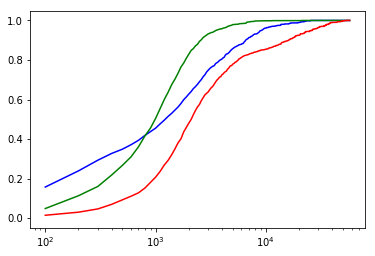

In [163]:
rng = range(0, int(max(tmode['density'])/100))
cum_d = cum_dens_by_type(['duplex'], rng)
cum_s = cum_dens_by_type(['small_apt'], rng)
cum_l = cum_dens_by_type(['large_apt'], rng)
xs = [i*100 for i in rng]
plt.semilogx(xs, cum_d, 'b-', xs, cum_s, 'g-', xs, cum_l, 'r-')
plt.show()

In [132]:
mode_map.groupby('age_mode').sum()['hunits']

age_mode
1939_older    32288977
1940_1949       767537
1950_1959     13742895
1960_1969      6424762
1970_1979     26844079
1980_1989     13262566
1990_1999     16772791
2000_2009     24809932
Name: hunits, dtype: int64

In [133]:
767537+13742895+6424762

20935194

In [134]:
26844079+13262566

40106645

In [135]:
16772791+24809932

41582723

In [136]:
16087+8601+23516

48204

In [137]:
29115+10489+1044

40648